<a href="https://colab.research.google.com/github/Tahira82/Image_Digit_Classification_LSTM/blob/main/Digit_classification_from_images_using_Long_Short_Term_Memory_Recurrent_Neural_Network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DL Assignment 3 - Recurrent Neural Networks for Image Classification

Welcome to the **third graded assignment** of the DL course. In the last labs we were using recurrent neural networks (RNNs) for next character and word prediction, text generation and sequence classification. So far, all these tasks were bound to natural language. Of course, RNNs can also process other types of data when presented as a sequence. In this assignment, you will use RNNs for **image classification**. In detail, you will build a **pixel wise** and a **row wise RNN** based on a **long short-term memory (LSTM)** and train them to classify digits from an image.


**Instructions**
- You'll be using Python 3 in the iPython based Google Colaboratory
- Lines encapsulated in "<font color='green'>`### START YOUR CODE HERE ###`</font>" and "<font color='green'>`### END YOUR CODE HERE ###`</font>", or marked by "<font color='green'>`# TODO`</font>", denote the code fragments to be completed by you.
- There's no need to write any other code.
- After writing your code, you can run the cell by either pressing `SHIFT`+`ENTER` or by clicking on the play symbol on the left side of the cell.
- We may specify "<font color='green'>`(≈ X LOC)`</font>" to tell you about how many lines of code you need to write. This is just a rough estimate, so don't feel bad if your code is longer or shorter.

**Much success!**

***

<font color='darkblue'>

**Remember**
- Run your cells using `SHIFT`+`ENTER` (or "Run cell")
- Write code in the designated areas using Python 3 only
- Do not modify the code outside of the designated areas
- Do not import/use any other packages. Code relying on packages other than the provided ones won't be graded.
- Activate GPU acceleration by clicking `Runtime` -> `Change runtime type` and select `GPU` from the dropdown menu entitled `Hardware accelerator`
</font>

***

<font color='red'>

**Note**
You have to develop and submit your own solution. If we have reasons to believe you shared or did not submit your own work, we have to consider an attempted fraud. In this case your submission will be graded zero points and we reserve additional measures.
</font>

***

# 0 - Preparation

## Imports and Test for GPU

Execute the cells below to import the required modules and test for GPU availability:

In [1]:
import numpy as np
import tensorflow as tf

!wget -nv -t 0 --show-progress https://cloud.tu-ilmenau.de/s/BpMm4QJpMqaiakS/download/utils.py

import utils

utils.py            100%[===================>]   5.14K  --.-KB/s    in 0s      
2023-11-16 14:01:58 URL:https://cloud.tu-ilmenau.de/s/BpMm4QJpMqaiakS/download/utils.py [5261/5261] -> "utils.py" [1]


In [2]:
#@title Print TF version and GPU stats
print('TensorFlow version:', tf.__version__)

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
   raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name), '', sep='\n')
!nvidia-smi

TensorFlow version: 2.14.0
Found GPU at: /device:GPU:0

Thu Nov 16 14:02:25 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   66C    P0    29W /  70W |    309MiB / 15360MiB |      1%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                

# 1 - Data Preparation

At first we need to load and prepare the dataset. In this assignment, you will be using the [MNIST database of handwritten digits](https://www.tensorflow.org/datasets/catalog/mnist). You will use [TensorFlow Datasets](https://www.tensorflow.org/datasets/overview) (`tdfs`) to load the data. The `tdfs` is a collection of ready-to-use datasets and conveniently handled as a utility module.

The next cell uses [`tfds.load`](https://www.tensorflow.org/datasets/overview#tfdsload) to load the train and test splits of MNIST as *supervised* dataset, i.e. with labels.

In [3]:
import tensorflow_datasets as tfds

def load_mnist():

  splits = tfds.load(
      'mnist',
      split=['train', 'test'],
      as_supervised=True,
  )

  return [split.shuffle(1024) for split in splits]

In [4]:
train_data, test_data = load_mnist()

Dl Completed...:   0%|          | 0/5 [00:00<?, ? file/s]

Dataset mnist downloaded and prepared to /root/tensorflow_datasets/mnist/3.0.1. Subsequent calls will reuse this data.


## 1.1 - Resize and Normalize Data for Row Wise Experiments

The train and test data is now stored as `tf.data.Dataset` objects. Let's define a model to augment data by random image transformations.

**TASK**: Complete the function `build_augmentation_model`. The augmentation model shall
1. randomly rotate an image by up to 36° in either direction.
2. randomly translate (shift) an image by up to 20% in either direction along the height and width,

Points **outside the boundaries** of the input shall be **filled with `constant` values**. If you are unsure which layer to use, check the TF documentation on [augmentation layers](https://www.tensorflow.org/guide/keras/preprocessing_layers#image_preprocessing). **Take care about the order of operations.**

In [34]:
# GRADED FUNCTION: build_augmentation_model (3 points)

from tensorflow.keras import layers, Sequential

def build_augmentation_model():

  ### START YOUR CODE HERE ###
  augmentation_model = Sequential([layers.RandomRotation(factor=0.1, fill_mode='constant'),
                                   layers.RandomTranslation(height_factor=0.2, width_factor=0.2, fill_mode='constant')])
  ### END YOUR CODE HERE ###

  return augmentation_model

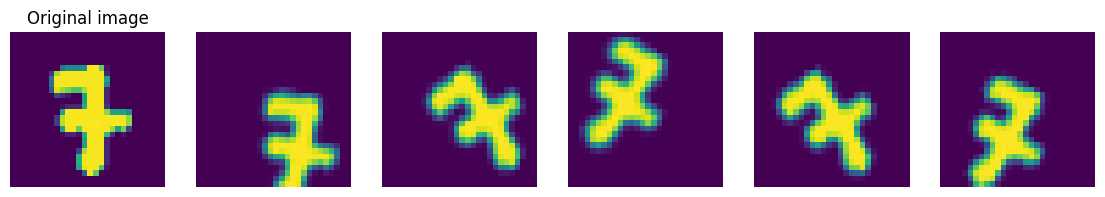

In [35]:
augmentation_model = build_augmentation_model()

utils.plot_augmentation_images(train_data, augmentation_model)

Let's check the shape of one sample:

In [36]:
print(f'Sample shape: {train_data.element_spec[0].shape}')

Sample shape: (28, 28, 1)


You should see a shape of `(28, 28, 1)`, i.e., a grayscale image with 28 by 28 pixels. In order to save computing time, you should **rescale the images to 14 by 14 pixels**. In addition, you need to **cast the pixel values to `float32` type and normalize their values to the interval `[0., 1.]`**.

To apply transformations to each element of a `Dataset` object, you can simply wrap the transformations in a function, e.g., `map_func`, and use the `map` method:

```python
def map_func(image, label) # the dataset is supervised, hence each sample has input `image` and output `label`
  ... any operation ...
  return image, label

dataset = dataset.map(map_func)
```

Note that you can stack calls to `map`:

```python
def map_func(image, label)
  ... any operation ...
  return image, label

def another_map_func(image, label)
  ... any other operation ...
  return image, label

dataset = dataset.map(map_func).map(another_map_func)
```

**TASKS**:
- Create a `resize_img` function to resize each image to 14 $\times$ 14 pixels. You may want to use the [`tf.image.resize`](https://www.tensorflow.org/api_docs/python/tf/image/resize) method for resizing.

- Also create a `normalize_img` function to cast the pixel values to `tf.float32` type and normalize the values to the range `[0., 1.]`. Check out the [`tf.cast`](https://www.tensorflow.org/api_docs/python/tf/cast) method.

- `map` your functions to the train and test data in the `load_row_class_data` function.

In [37]:
# GRADED FUNCTION: resize_img (1 point)
# GRADED FUNCTION: normalize_img (1 point)
# GRADED FUNCTION: load_row_class_data (2 points)

BATCH_SIZE = 512

### START YOUR CODE HERE ### ( ≈ 6 LOC)
def resize_img(image, label):
  image = tf.image.resize(image, [14,14])
  return image, label

def normalize_img(image, label):
  image = tf.cast(image, dtype=tf.float32)
  image = tf.image.per_image_standardization(image)
  return image, label

### END YOUR CODE HERE ###


def load_row_class_data(augment=True):

  # load the mnist dataset
  train_data, test_data = load_mnist()
  test_data = test_data.take(1000) # test only on 1k samples

  if augment:
    train_data = train_data.map(lambda x, y: (augmentation_model(x), y))

  ### START YOUR CODE HERE ### ( ≈4 LOC)
  # resize and normalize the train images
  train_data = train_data.map(resize_img).map(normalize_img)
  # resize and normalize the test images
  test_data = test_data.map(resize_img).map(normalize_img)

  ### END YOUR CODE HERE ###

  # create batches
  train_data = train_data.cache().batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)
  test_data = test_data.cache().batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)

  return train_data, test_data

Now load the processed dataset and take a look on a sample. The shape of each batch of this dataset should be `(None, 14, 14, 1)`. The plotted image should display a digit.

**NOTE**: If your augmentation model does not work, set the `augment` argument to `False`.

Batch shape (row wise data): (None, 14, 14, 1)


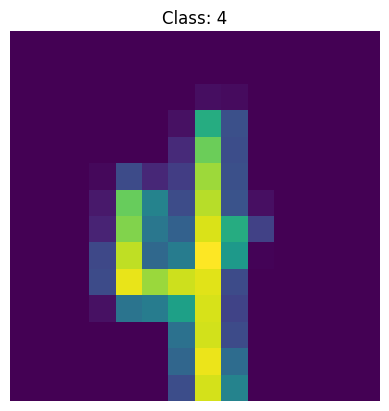

In [38]:
row_train_data, row_test_data = load_row_class_data(augment=True)

print(f'Batch shape (row wise data): {row_train_data.element_spec[0].shape}')

utils.show_dataset_sample(row_train_data)

## 1.2 - Reshape Data for Pixel by Pixel Experiments

In order to forward the image through the RNN as a sequence of pixels, you need to reshape each image to the shape `( width * height, 1)`.

**TASKS**:
- Create a `reshape_img` function to reshape each image to `( width * height, 1)`. You may want to use the [`tf.reshape`](https://www.tensorflow.org/api_docs/python/tf/reshape) method.

- Map your functions to the train and test data in the `load_pixel_class_data` function.



In [39]:
# GRADED FUNCTION: reshape_img (1 point)
# GRADED FUNCTION: load_px_class_data (1 point)

### START YOUR CODE HERE ### ( ≈ 3 LOC)
def reshape_img(image, label):
  image = tf.reshape(image, [image.shape[0] * image.shape[1], 1])
  return image, label

### END YOUR CODE HERE ###

def load_px_class_data(augment=True):

  # load the mnist dataset
  train_data, test_data = load_mnist()
  test_data = test_data.take(1000) # test only on 1k samples

  if augment:
    train_data = train_data.map(lambda x, y: (augmentation_model(x), y))

  ### START YOUR CODE HERE ### ( ≈ 6 LOC)
  # resize, normalize, and reshape the train images
  train_data = train_data.map(resize_img).map(normalize_img).map(reshape_img)
  # resize, normalize, and reshape the test images
  test_data = test_data.map(resize_img).map(normalize_img).map(reshape_img)

  ### END YOUR CODE HERE ###

  # create batches
  train_data = train_data.cache().batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)
  test_data = test_data.cache().batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)

  return train_data, test_data

Now load the processed pixel wise dataset and take a look on a sample. The shape of a batch of reshaped samples should be `(None, 196, 1)`. The plotted image should still display a digit because the data is reshaped back in the plotting function.

Batch shape (pixel wise data): (None, 196, 1)


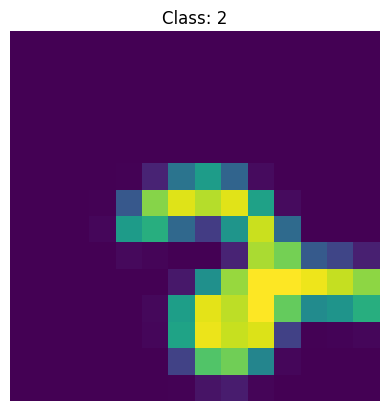

In [40]:
px_train_data, px_test_data = load_px_class_data(augment=True)

print(f'Batch shape (pixel wise data): {px_train_data.element_spec[0].shape}')

utils.show_dataset_sample(px_train_data)

If you did everything right, you should now have **two variants of the MNIST dataset**:
1. `(px_train_data, px_test_data)` for forwarding the image **pixel by pixel** through the RNN. Therefore, a batch must have the shape `(None, 196, 1)`. You will use this dataset as a sequence with **196 timesteps** and **1 feature per timestep**.
2. `(row_train_data, row_test_data)` for forwarding the image **row by row** through the RNN. Therefore, a batch must have the shape `(None, 14, 14, 1)`. You will use this dataset as a sequence with **14 timesteps** and **14 features per timestep**.

# 2 - Build Model

Now it's time to build your model. We suggest you to build a stacked RNN with three [**LSTM** layers](https://www.tensorflow.org/api_docs/python/tf/keras/layers/LSTM) and one **Dense** layer for classification. All LSTM layers shall have the same `hidden_size`, i.e., number of units.
Note that the second and third LSTM layers in the stack expect an input for each timestep. Hence, the first and second LSTM layers must return an output at each timestep.

**TASK**: Complete the function `build_classification_model` by designing a classification RNN with three LSTM layers and one Dense layer. The model compilation will be done later.

In [41]:
# GRADED FUNCTION: build_classification_model (2 points)

from tensorflow.keras import layers
from tensorflow.keras.models import Model

def build_classification_model(
    input_timesteps: int,
    input_features_size: int,
    hidden_size: int,
    num_classes: int,
    summary: bool=True,
    ):
  """Build LSTM-based model for sequence classification.

  Args:
    input_timesteps (int): number of input timesteps
    input_features_size (int): number of input features per timestep
    hidden_size (int): hidden size of the LSTM (=number of units),
    num_classes (int): number of classes,
    augmentation_model (Model): keras model for augmentation (default: None),
    summary (bool=True): print model summary

  Returns:
      model (tf.keras.Model): built TensorFlow Keras Model
  """

  ### START YOUR CODE HERE ### (≈ 6 LOC)
  input = layers.Input(shape=(input_timesteps, input_features_size), batch_size=BATCH_SIZE)
  x = layers.LSTM(hidden_size, return_sequences=True)(input)
  x = layers.LSTM(hidden_size, return_sequences=True)(x)
  x = layers.LSTM(hidden_size)(x)
  output = layers.Dense(num_classes,
                     activation='softmax'
                     )(x)

  your_model = Model(input, output, name='classification_model')
  ### END YOUR CODE HERE ###

  if summary:
    print(your_model.summary())

  return your_model

Test your function by creating an instance of your model. Think about the correct values for the `input_timesteps`, `input_features_size` for the pixel by pixel data.

In [42]:
### START YOUR CODE HERE ### (1 LOC)
lstm_model = build_classification_model(196, 1, 15, 10)
### END YOUR CODE HERE ###

Model: "classification_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(512, 196, 1)]           0         
                                                                 
 lstm_18 (LSTM)              (512, 196, 15)            1020      
                                                                 
 lstm_19 (LSTM)              (512, 196, 15)            1860      
                                                                 
 lstm_20 (LSTM)              (512, 15)                 1860      
                                                                 
 dense_6 (Dense)             (512, 10)                 160       
                                                                 
Total params: 4900 (19.14 KB)
Trainable params: 4900 (19.14 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


# 3 - Train and Evaluate Pixel by Pixel Model

## 3.1 - Callbacks

The next cells sets up callbacks to reduce the learning rate and to stop the training if the model does not improve anymore:

In [43]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

def set_up_callbacks():

  reduce_lr_on_plateau_callback = ReduceLROnPlateau(
      monitor='val_loss',
      factor=0.2,
      patience=10,
      min_lr=0.0001,
      verbose=1
  )

  early_stopping_callback = EarlyStopping(
      monitor='val_loss',
      patience=20,
      restore_best_weights=True,
      verbose=1
  )

  return reduce_lr_on_plateau_callback, early_stopping_callback

## 3.2 - Model Training

Now it's time to create an instance of your model and start the training. Start with the pixel by pixel model and train the model on the `px_train_data`. We suggest to set `hidden_size = 8`, but you can choose other values if you like.
Think about the correct values for `input_timesteps` (= number of timesteps) and `feature_size` (= number of features per timestep).

**TASK**: Complete the function `run_px_classification_experiment` to perform the pixel by pixel classification experiments.
- Load the pixel by pixel dataset.
- Create an instance of your model from Section 1.2.
- Compile the model using `SparseCategoricalCrossentropy` loss, `RMSprop` optimizer with a learning rate of $10^{-2}$, `accuracy` as metric.
- Train the model for `num_epochs` epochs.
- Don't forget the callbacks.
- Return the training history and trained model.

In [44]:
# GRADED FUNCTION: run_px_classification_experiment (5 points)

from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.losses import SparseCategoricalCrossentropy

def run_px_classification_experiment(num_epochs :int=100):

  ### START YOUR CODE HERE ### (≈ 5 LOC)

  # load data
  train_data = px_train_data
  val_data = px_test_data
  # build model
  HIDDEN_SIZE = 8
  NUM_CLASSES = 10
  lstm_model = build_classification_model(train_data.element_spec[0].shape[1], train_data.element_spec[0].shape[2], HIDDEN_SIZE, NUM_CLASSES)
  # compile model
  lstm_model.compile(
      loss='sparse_categorical_crossentropy',
      optimizer=RMSprop(learning_rate=1e-2),
      metrics=['accuracy'])
  # train model
  train_model_history = lstm_model.fit(train_data,
                               epochs=num_epochs,
                               validation_data= val_data,
                               callbacks=set_up_callbacks(), batch_size=BATCH_SIZE)
  # return model and history
  return lstm_model, train_model_history
  ### END YOUR CODE HERE ###

Now run the experiment. Your model should reach a validation accuracy > 50% within the first ten epochs. After 50 epochs the validation accuracy should be >80%:

Model: "classification_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(512, 196, 1)]           0         
                                                                 
 lstm_21 (LSTM)              (512, 196, 8)             320       
                                                                 
 lstm_22 (LSTM)              (512, 196, 8)             544       
                                                                 
 lstm_23 (LSTM)              (512, 8)                  544       
                                                                 
 dense_7 (Dense)             (512, 10)                 90        
                                                                 
Total params: 1498 (5.85 KB)
Trainable params: 1498 (5.85 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/1

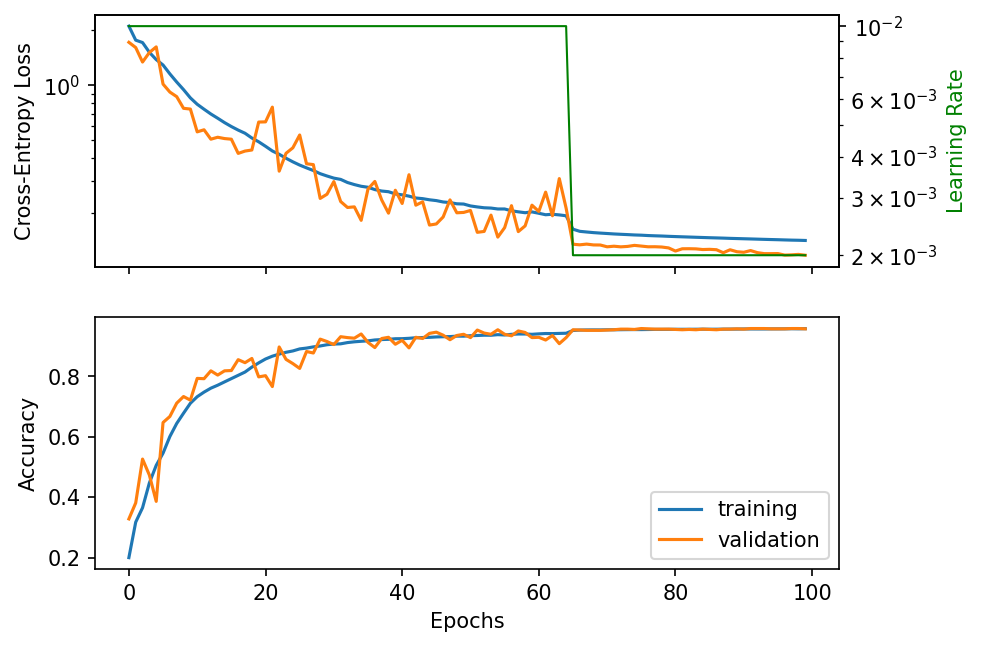

In [45]:
px_class_model, px_class_history = run_px_classification_experiment(num_epochs=100)
utils.plot_history(px_class_history)

## 3.3 - Investigate Continuous Model Predictions

Instead of performing the classification based on the LSTM cell's output at the end of the sequence, you can also analyze your models' predictions at each timestep.

To do so, you only need to build a model with essentially the same architecture and ensure that each LSTM layer returns an output at each timestep. Then the classifier receives an input at each timestep and returns a prediction accordingly.

**TASK**: Create a model with same architecture as in Section 1.2 but returning a prediction at each timestep.


In [46]:
# GRADED FUNCTION: build_continuous_classification_model (1 point)

def build_continuous_classification_model(
    input_timesteps: int,
    input_features_size: int,
    hidden_size: int,
    num_classes: int,
    summary: bool=True,
    ):
  """Build LSTM-based model for sequence classification.

  Args:
    input_timesteps (int): number of input timesteps
    input_features_size (int): number of input features per timestep
    hidden_size (int): hidden size of the LSTM (=number of units),
    num_classes (int): number of classes,
    summary (bool=True): print model summary

  Returns:
      model (tf.keras.Model): built TensorFlow Keras Model
  """

  ### START YOUR CODE HERE ### (≈ 6 LOC)
  input = layers.Input(shape=(input_timesteps, input_features_size), batch_size=BATCH_SIZE)
  x = layers.LSTM(hidden_size, return_sequences=True)(input)
  x = layers.LSTM(hidden_size, return_sequences=True)(x)
  x = layers.LSTM(hidden_size, return_sequences=True)(x)

  output = layers.Dense(10, activation='softmax')(x)

  your_model = Model(input, output, name='new_classification_model')
  ### END YOUR CODE HERE ###

  if summary:
    print(your_model.summary())

  return your_model

Next, create an instance of the continuous pixel by pixel model `px_class_model_continuous` and transfer the weights from the trained `px_class_model`:

In [47]:
### START YOUR CODE HERE ### (1 LOC)
HIDDEN_SIZE = 8
NUM_CLASSES = 10
px_class_model_continuous = build_continuous_classification_model(px_train_data.element_spec[0].shape[1],
                                                                  px_train_data.element_spec[0].shape[2], HIDDEN_SIZE, NUM_CLASSES

)
### END YOUR CODE HERE ###
# transfer weights from trained model
px_class_model_continuous.set_weights(px_class_model.get_weights())

Model: "new_classification_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(512, 196, 1)]           0         
                                                                 
 lstm_24 (LSTM)              (512, 196, 8)             320       
                                                                 
 lstm_25 (LSTM)              (512, 196, 8)             544       
                                                                 
 lstm_26 (LSTM)              (512, 196, 8)             544       
                                                                 
 dense_8 (Dense)             (512, 196, 10)            90        
                                                                 
Total params: 1498 (5.85 KB)
Trainable params: 1498 (5.85 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


Execute the cell below to take one sample from the test dataset and forward propagate it through the network. If everything is correct, the number of predictions is equal to the number of timesteps:

In [48]:
sample_idx = 42

px_sample = utils.get_dataset_sample(px_test_data, sample_idx)
continuous_predictions = np.array(px_class_model_continuous.predict( np.expand_dims(px_sample[0], 0)))[0,:]
print(f'Number of predictions: {len(continuous_predictions)}')

1/1 [==============================] - 1s 911ms/step
Number of predictions: 196


Use the `plot_continuous_classification` function defined above to create an interactive plot of the probability distribution and processed image. Use the slider to navigate through the sequence. Can you predict the correct digit before your RNN?

In [49]:
utils.plot_continuous_classification(px_sample[0], continuous_predictions)

# 4 - Train and Evaluate Row by Row Model

## 4.1 - Model Training

You should have observed that the pixel by pixel model can make some erratic predictions with progressing timesteps. Of course, memorizing a long series of mostly zero pixel values can be a complicated task.

If you process the image row by row, more context is added for each timestep and we can expect better model performance. Next, you shall train a row-wise model to evaluate this hypothesis.

**TASK**: Complete the function `run_row_classification_experiment` to perform the row by row classification experiments.
- Load the row by row dataset.
- Create an instance of your model from Section 1.2. Think about the correct number of time steps and features per time step.
- Compile the model using `SparseCategoricalCrossentropy` loss, `RMSprop` optimizer with a learning rate of $10^{-2}$, `accuracy` as metric.
- Train the model for `num_epochs` epochs. Don't forget your callbacks!
- Return the training history and trained model.

In [52]:
# GRADED FUNCTION: run_row_classification_experiment (1 point)

def run_row_classification_experiment(num_epochs :int=100):

  ### START YOUR CODE HERE ### (≈ 5 LOC)
  # load data
  train_data = row_train_data
  val_data = row_test_data
  # build model
  HIDDEN_SIZE = 8
  NUM_CLASSES = 10
  lstm_row_model = build_classification_model(train_data.element_spec[0].shape[1], train_data.element_spec[0].shape[2], HIDDEN_SIZE, NUM_CLASSES)
  # compile model
  lstm_row_model.compile(
         loss='sparse_categorical_crossentropy',
         optimizer=RMSprop(learning_rate=1e-2),
         metrics=['accuracy'])
  # train model
  train_model_history = lstm_row_model.fit(train_data,
                               epochs=num_epochs,
                               validation_data= val_data,
                               callbacks=set_up_callbacks(), batch_size=BATCH_SIZE)
  # return model and history
  return lstm_row_model, train_model_history

  ### END YOUR CODE HERE ###

Now run the experiment. Your model should reach a validation accuracy > 90% within the first ten epochs.

Model: "classification_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(512, 14, 14)]           0         
                                                                 
 lstm_30 (LSTM)              (512, 14, 8)              736       
                                                                 
 lstm_31 (LSTM)              (512, 14, 8)              544       
                                                                 
 lstm_32 (LSTM)              (512, 8)                  544       
                                                                 
 dense_10 (Dense)            (512, 10)                 90        
                                                                 
Total params: 1914 (7.48 KB)
Trainable params: 1914 (7.48 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/1

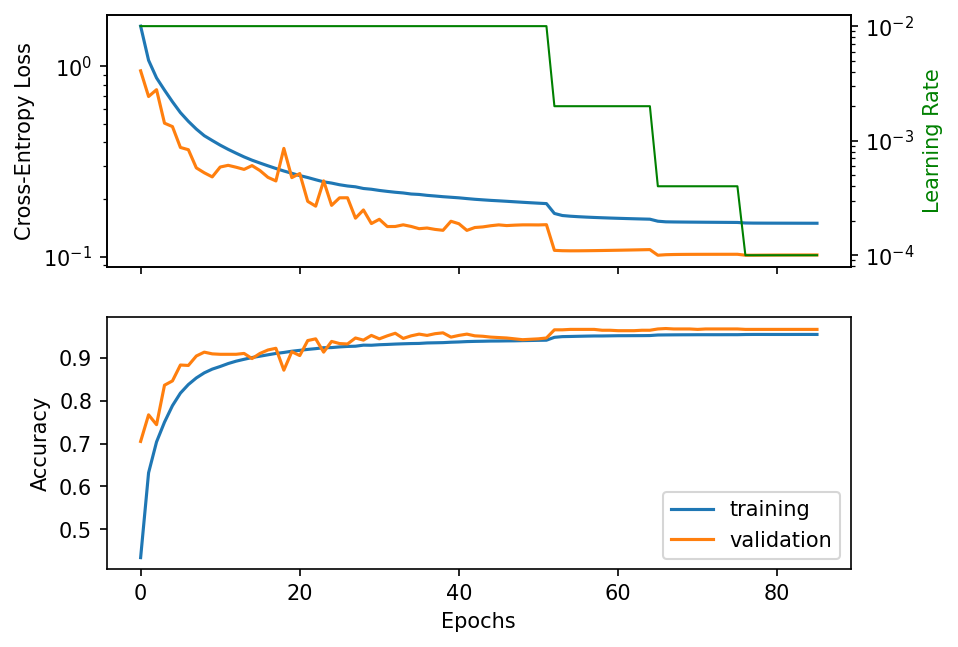

In [53]:
row_class_model, row_class_history = run_row_classification_experiment()
utils.plot_history(row_class_history)

## 4.2 - Investigate Continuous Model Predictions

Same as for the pixel wise model, let's analyse the prediction at each time step.

**TASK**: Create an instance of the continuous row by row model `row_class_model_continuous`.

In [54]:
### START YOUR CODE HERE ### (1 LOC)
HIDDEN_SIZE = 8
NUM_CLASSES = 10
row_class_model_continuous = build_continuous_classification_model(row_train_data.element_spec[0].shape[1],
                                                                  row_train_data.element_spec[0].shape[2], HIDDEN_SIZE, NUM_CLASSES

)
### END YOUR CODE HERE ###

# transfer weights from trained model
row_class_model_continuous.set_weights(row_class_model.get_weights())

Model: "new_classification_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(512, 14, 14)]           0         
                                                                 
 lstm_33 (LSTM)              (512, 14, 8)              736       
                                                                 
 lstm_34 (LSTM)              (512, 14, 8)              544       
                                                                 
 lstm_35 (LSTM)              (512, 14, 8)              544       
                                                                 
 dense_11 (Dense)            (512, 14, 10)             90        
                                                                 
Total params: 1914 (7.48 KB)
Trainable params: 1914 (7.48 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


Execute the cell below to take one sample from the test dataset and forward propagate it through the network. If everything is correct, the number of predictions is equal to the number of timesteps:

In [55]:
sample_idx = 42

row_sample = utils.get_dataset_sample(row_test_data, sample_idx)
continuous_predictions = np.array(row_class_model_continuous.predict( np.expand_dims(row_sample[0], 0)))[0,:]

print(f'Number of predictions: {len(continuous_predictions)}')

1/1 [==============================] - 1s 894ms/step
Number of predictions: 14


And plot the result:

In [56]:
utils.plot_continuous_classification(row_sample[0], continuous_predictions)

***

**TASK**: Compare the number of parameters of the first LSTM layer in the pixel by pixel model to the number of parameters of the first LSTM layer in the row by row model. Explain how the number of parameters is calculated and why they are different in the two models.

# **GRADED RESPONSE**: (2 points)
First LSTM layer has 736 parameters in row by row model and 320 parameters in pixel by pixel model. The number of parameters in one LSTM layer can be found as follows: (input dimension + number of previous lstm units' input + bias dimension) * number of lstm units * number of functions with trainable parameters in a cell.
The number of parameters are different due to different input feature size in both models.
Row by row model has input feature size = 14.
So, number of parameters = (14+8+1)* 8 * 4 = 736
Pixel by pixel model has input feature size = 1.
So, number of parameters = (1+8+1)* 8 * 4 = 320

---

# Congratulations on completing Assignment 3!

Complete the steps below for submission.

# Submission Instructions

You may now submit your notebook to moodle:
- Save the notebook (`CTRL`+ `s` or '*File*' -> '*Save*')
- Click on '*File*' -> '*Download .ipynb*' for downloading the notebook as IPython Notebook file.
- Upload the downloaded IPython Notebook file to **Moodle**.